# Prediction of energy market prices (part 1)

You are given meteorological and market data for part of 2025. [Meteorological data file](https://github.com/jkved/enerheads-quant-challenge/blob/main/data/weather_location_Vilnius.csv)(s) contains day-ahead and intraday forecasts for meteorological variables for a single location. The data description is available on [OpenMeteo](https://open-meteo.com/en/docs) docs and the timezone here is in UTC. This will contain some of your predictors values. Day ahead value (with suffix `previous_day1`) is known 24 hours before delivery time, intraday (no suffix column) is around 1 hour before or at delivery time. Market data (predictors and target values) is given in file [market data file](https://github.com/jkved/enerheads-quant-challenge/blob/main/data/market_data.csv), the data is also publicly available on [Baltic transparency dashboard](https://baltic.transparency-dashboard.eu/). Here index is in UTC timezone and two columns here are considered our target variables:
- `10YLT-1001A0008Q_DA_eurmwh` - this is Nord Pool day-ahead auction cleared prices (EUR/MWh). It is resolved day before delivery day (day-ahead), i.e. today at 10:00 UTC we find out prices for tommorrow CET day (22:00 UTC today -> 22:00 UTC tommorrow). Only weather data with `previous_day1` suffix is available at inference time
- `LT_up_sa_cbmp` or `LT_down_sa_cbmp` - this is mFRR activation prices. Generally only up or down activations take place at the same time so price is duplicated in these columns. It is resolved at delivery time (intraday). All weather data and Nord Pool prices are available at inference time but all other market data is visible with a 30 minute lag, i.e. for an mFRR activation price @ 11:00, all other market data is visible only up to (not including) 10:30.

Complete the following tasks:

1. Create Nord Pool prices forecasting model in day-ahead setting.
2. Create mFRR prices forecasting model in intraday setting
3. Implement certain evaluation metrics for prices:
   - you wish to accurately guess times when smallest and largest prices of the day take shape.
   - you wish to know how many instances there are with spreads between smallest and largest prices being bigger than X (say, 200 EUR/MWh).
4. Choose a collection of 2-3 plots to visualize the performance of both models.

    


# Table of Contents


# Introduction

# Importing the Data

In [1]:
from functools import reduce
import glob
import os

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import warnings

from utils import get_time_of_day, get_season

In [2]:
warnings.filterwarnings("ignore")

In [3]:
market_df = pd.read_csv("data/market_data.csv", index_col=0)
market_df.index = pd.to_datetime(market_df.index, utc=True)
print(market_df.shape)
market_df.head()

(11424, 100)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


In [4]:
market_df.tail()

,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-06-27 22:45:00+00:00,0.0,7.996,0.0,10.580,0.0,9.07,20.70,128.30,-149.55,10.0,...,0.0,-1.00,0.0,-1,-1.0,-1.0,-111.89,-119.82,-113.94,9.98
2025-06-27 23:00:00+00:00,0.0,4.968,0.0,10.286,0.0,5.92,20.66,100.00,-149.47,10.0,...,0.0,-9.70,0.0,-1,-1.0,-1.0,-73.98,-13.40,-30.97,9.98
2025-06-27 23:15:00+00:00,0.0,3.718,0.0,9.045,0.0,0.70,19.68,19.68,-149.03,0.0,...,0.0,-9.70,0.0,-1,-1.0,-1.0,-13.41,3.70,43.23,9.98
2025-06-27 23:30:00+00:00,0.0,4.742,0.0,9.524,0.0,4.92,19.21,19.21,-149.73,0.0,...,0.0,-14.94,0.0,-1,-1.0,-1.0,-26.88,-2.27,28.08,9.98
2025-06-27 23:45:00+00:00,0.0,7.403,0.0,10.516,0.0,11.77,19.49,19.49,-149.15,0.0,...,0.0,-9.70,0.0,-1,-1.0,-1.0,-136.13,-117.38,-128.90,9.98


Weather data from different cities will be treated as separate features and will be imported as columns in the format `weather_feature_city`.

In [5]:
files = glob.glob("data/weather_location_*.csv")
dfs = []

for file in files:
    city = os.path.splitext(os.path.basename(file))[0].replace("weather_location_", "")
    df = pd.read_csv(file, index_col=0)
    df = df.rename(columns={col: f"{col}_{city}" for col in df.columns})
    
    dfs.append(df)

weather_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)
print(weather_df.shape)
weather_df.head()

(2856, 140)


,wind_speed_80m_Alytus,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_Alytus,cloud_cover_previous_day1_Alytus,...,direct_radiation_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,13.333627,13.684512,125.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0
2025-03-01 01:00:00+00:00,12.280973,14.737166,123.0,99.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0
2025-03-01 02:00:00+00:00,13.333627,12.631857,118.0,101.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.8735,1.8235,89.0,90.0
2025-03-01 03:00:00+00:00,11.228318,9.473893,130.0,102.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.7735,1.8235,89.0,89.0
2025-03-01 04:00:00+00:00,9.123008,7.368583,152.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9235,1.7235,90.0,90.0


In [6]:
weather_df.tail()

,wind_speed_80m_Alytus,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_Alytus,cloud_cover_previous_day1_Alytus,...,direct_radiation_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-06-27 19:00:00+00:00,29.474333,29.123451,290.0,285.0,0.0,0.0,3.0,1.0,100.0,100.0,...,0.0,0.0,3.0,1.0,100.0,100.0,16.5235,16.4235,88.0,90.0
2025-06-27 20:00:00+00:00,30.526989,32.983180,283.0,286.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,16.3735,16.1735,88.0,90.0
2025-06-27 21:00:00+00:00,37.193806,36.842920,285.0,288.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,16.1735,16.0235,89.0,88.0
2025-06-27 22:00:00+00:00,32.632298,32.632298,284.0,282.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,16.1235,15.7235,89.0,91.0
2025-06-27 23:00:00+00:00,25.614600,28.421680,279.0,276.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,15.8235,15.6235,90.0,92.0


We have data from 2025-03-01  to 2025-06-27, which is consistant in both data frames and in weather data by city. Since each task require a different approach for the optimization I will prepare the data frames for that particucal task. Now lets just quicly look at how many `NaN`s or diplicated values we have.

In [7]:
weather_df.isna().sum().sum()

0

In [8]:
market_df.isna().sum()[market_df.isna().sum() != 0].sort_values(ascending=False).head(40)

LV_up_da_cbmp                10194
LV_down_da_cbmp              10194
LV_procur_afrr_up_price       9718
LV_procur_afrr_down_price     9718
EE_procur_afrr_down_price     9694
EE_procur_afrr_up_price       9694
LT_procur_afrr_up_price       9670
LT_procur_afrr_down_price     9670
EE_procur_afrr_down_vol       9215
EE_procur_afrr_up_vol         9215
LV_procur_afrr_down_vol       9215
LT_procur_afrr_up_vol         9215
LT_procur_afrr_down_vol       9215
LV_procur_afrr_up_vol         9215
LV_procur_mfrr_down_price     8828
LV_procur_mfrr_up_price       8828
LV_procur_mfrr_up_vol         8577
LV_procur_mfrr_down_vol       8577
EE_procur_FCR_price           8568
LT_procur_FCR_price           8568
LT_procur_mfrr_down_vol       8568
LT_procur_mfrr_up_vol         8568
LV_procur_FCR_vol             8568
EE_procur_mfrr_down_vol       8568
EE_procur_mfrr_up_vol         8568
EE_procur_FCR_vol             8568
LT_procur_mfrr_down_price     8568
LT_procur_mfrr_up_price       8568
LT_procur_FCR_vol   

Let's leave only the columns that have more than 50% of values that are not `NaN`

In [9]:
percent_missing = 0.5
market_df_filtered = market_df.loc[:, market_df.isnull().mean() < percent_missing]
print(market_df_filtered.shape)
market_df_filtered.head()

(11424, 68)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


In [10]:
weather_df.duplicated().sum()

0

In [11]:
market_df_filtered.duplicated().sum()

0

# Nord Pool prices forecasting model in day-ahead setting

For more details on model creation, refer to the `Appendix_1.ipynb` notebook.
Since only features containing `*_previous_day1_*` will be available, I’ll create a DataFrame containing just those columns.

In [12]:
weather_features = [col for col in weather_df.columns if "_previous_day1_" in col]
weather_prev_day_df = weather_df[weather_features]
print(weather_prev_day_df.shape)
weather_prev_day_df.head()

(2856, 70)


,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_previous_day1_Alytus,temperature_2m_previous_day1_Alytus,relative_humidity_2m_previous_day1_Alytus,wind_speed_80m_previous_day1_Kaunas,wind_direction_80m_previous_day1_Kaunas,direct_radiation_previous_day1_Kaunas,...,cloud_cover_previous_day1_Utena,temperature_2m_previous_day1_Utena,relative_humidity_2m_previous_day1_Utena,wind_speed_80m_previous_day1_Vilnius,wind_direction_80m_previous_day1_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,13.684512,87.0,0.0,0.0,100.0,0.8285,96.0,16.140705,67.0,0.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 01:00:00+00:00,14.737166,99.0,0.0,0.0,100.0,0.7285,97.0,15.088053,66.0,0.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 02:00:00+00:00,12.631857,101.0,0.0,0.0,100.0,0.7285,96.0,14.386281,60.0,0.0,...,100.0,0.848,98.0,11.930088,87.0,0.0,0.0,100.0,1.8235,90.0
2025-03-01 03:00:00+00:00,9.473893,102.0,0.0,0.0,100.0,0.6285,97.0,14.386281,49.0,0.0,...,100.0,0.798,98.0,10.526547,84.0,0.0,0.0,100.0,1.8235,89.0
2025-03-01 04:00:00+00:00,7.368583,87.0,0.0,0.0,100.0,0.5285,97.0,15.438937,40.0,0.0,...,100.0,0.748,98.0,9.473893,70.0,0.0,0.0,100.0,1.7235,90.0


In [13]:
weather_upsampled = weather_prev_day_df.loc[weather_prev_day_df.index.repeat(4)].copy()
weather_upsampled.index = market_df_filtered.index
merged_df = pd.concat([market_df_filtered, weather_upsampled], axis=1)

print(merged_df.shape)
merged_df.head(8)

(11424, 138)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,cloud_cover_previous_day1_Utena,temperature_2m_previous_day1_Utena,relative_humidity_2m_previous_day1_Utena,wind_speed_80m_previous_day1_Vilnius,wind_direction_80m_previous_day1_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:15:00+00:00,3.061,0.000,3.315,0.0,0.00,2.38,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:30:00+00:00,2.250,0.000,3.379,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:45:00+00:00,0.517,0.684,1.854,0.0,0.00,2.42,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0


Let's create some new features that might influence the usage of electricity. 

In [14]:
df = merged_df.copy()

df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["time_of_day"] = df["hour"].apply(get_time_of_day)
df["season"] = df["month"].apply(get_season)
df["time_of_day"] = df["time_of_day"].astype("category")
df["season"] = df["season"].astype("category")

print(df.shape)
df.head()

(11424, 143)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius,hour,dayofweek,month,time_of_day,season
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.7735,91.0,1,5,3,night,spring


Lets define targets and training features for the model, and split the data into testing and training sets.

In [15]:
targets = ["10YLT-1001A0008Q_DA_eurmwh", "LT_up_sa_cbmp", "LT_down_sa_cbmp"]
features =  [col for col in df.columns if col not in targets]

# It is sorted by time but better safe than sorry
df = df.sort_index()

split_idx = int(len(df) * 0.8)
X_train = df[features].iloc[:split_idx]
y_train = df[targets[0]].iloc[:split_idx]
X_test = df[features].iloc[split_idx:]
y_test = df[targets[0]].iloc[split_idx:]

## XGBoost

Here I will choose to optimize the parameters of the XGBoost model on Mean Average Error (MAE) and I will evaluate some price specific metrics here below. But creating a model to optimize on the custom funvtions didn't give a good model. 

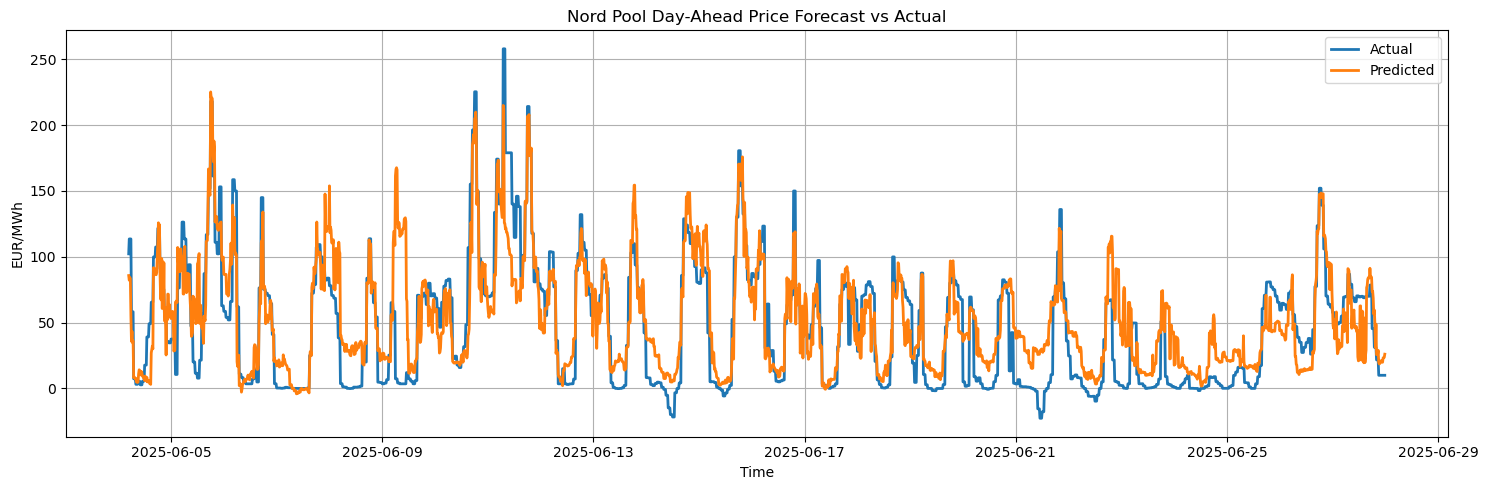

In [16]:
xgb_model = XGBRegressor(
    random_state=9,
    subsample=0.8,
    enable_categorical=True,
    tree_method="hist",
    n_jobs=-1,
    colsample_bytree=0.5,
    learning_rate=0.025,
    max_depth=4,
    n_estimators=400
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_xgb, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 features XGBoost:
LT_mfrr_SA_down_max_bid                    0.123675
EE_mfrr_SA_down_max_bid                    0.082882
diffuse_radiation_previous_day1_Telsiai    0.047582
EE_mfrr_SA_up_min_bid                      0.046531
LV_mfrr_SA_down_max_bid                    0.040506
LT_mfrr_SA_down_min_bid                    0.031494
month                                      0.029021
LT_mfrr_SA_up_max_bid                      0.028669
diffuse_radiation_previous_day1_Taurage    0.026593
diffuse_radiation_previous_day1_Kaunas     0.025863
dtype: float32


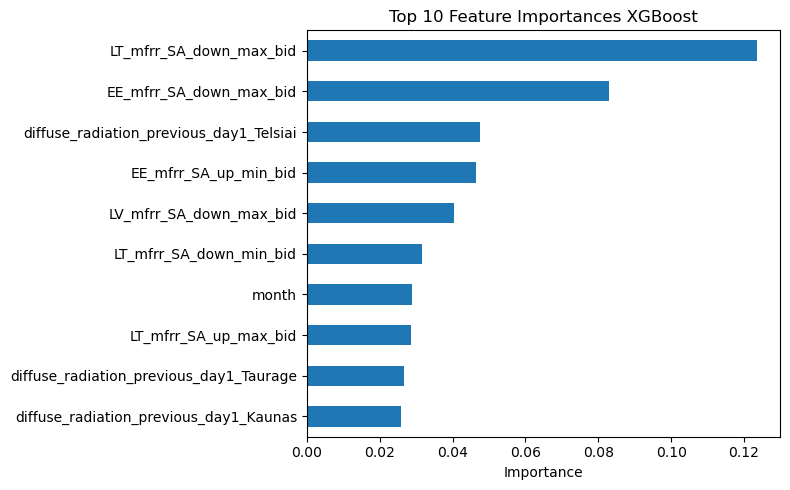

In [19]:
importances_xgb = pd.Series(
    xgb_model.feature_importances_, index=xgb_model.feature_names_in_
).sort_values(ascending=False)

print("Top 10 features XGBoost:")
print(importances_xgb.head(10))

importances_xgb.head(10).plot(
    kind="barh", figsize=(8, 5), title="Top 10 Feature Importances XGBoost"
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

The model demonstrates strong forecasting ability for the near future, with performance gradually decreasing as the prediction horizon extends further. This decline in longer-term accuracy is not a concern for our use case, as our primary objective is short-term forecasting. Furthermore, the model can be periodically retrained to maintain high accuracy for near-term predictions.

# Prediction of energy market prices mFRR
## LightGBM



In [20]:
market_df_filtered.loc[:, "LT_up_sa_cbmp"] = market_df_filtered["LT_up_sa_cbmp"].interpolate(
    method="linear", limit_direction="both"
)
shift = abs(market_df_filtered["LT_up_sa_cbmp"].min()) + 1
market_df_filtered["LT_up_sa_cbmp_log"] = np.log(market_df_filtered["LT_up_sa_cbmp"] + shift)

targets = ["10YLT-1001A0008Q_DA_eurmwh", "LT_up_sa_cbmp", "LT_down_sa_cbmp", "LT_up_sa_cbmp_log"]
target = targets[3]
features =  [col for col in market_df_filtered.columns if col not in targets]

lagged_market = market_df_filtered[features].shift(2)
lagged_market.head()

,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LV_up_sa_cbmp,LV_down_sa_cbmp,LT_up_da_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.0,400.0,927.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,927.02
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.0,400.0,400.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,932.81
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.5,400.0,927.0,-273.0,20.0,...,27.27,27.27,NaN,NaN,1.0,-1.0,1.0,400.0,10.19,119.23


In [22]:
weather_upsampled = weather_df.loc[weather_df.index.repeat(4)].copy()
weather_upsampled.index = market_df_filtered.index
merged_df = pd.concat([
    lagged_market,
    market_df_filtered[["10YLT-1001A0008Q_DA_eurmwh"]], 
    weather_upsampled,
    market_df_filtered[["LT_up_sa_cbmp_log"]] 
], axis=1)

print(merged_df.shape)
merged_df.head(8)

(11424, 207)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius,LT_up_sa_cbmp_log
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,9.213064
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,9.213064
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,9.213064
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0,9.213064
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,9.213064
2025-03-01 01:15:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,9.213064
2025-03-01 01:30:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,9.213064
2025-03-01 01:45:00+00:00,3.061,0.000,3.315,0.0,0.00,2.38,400.0,927.0,-273.0,20.0,...,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0,9.213064


In [23]:
df = merged_df.copy()

df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["time_of_day"] = df["hour"].apply(get_time_of_day)
df["season"] = df["month"].apply(get_season)
df["time_of_day"] = df["time_of_day"].astype("category")
df["season"] = df["season"].astype("category")

print(df.shape)
df.head()

(11424, 212)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius,LT_up_sa_cbmp_log,hour,dayofweek,month,time_of_day,season
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1235,1.8235,89.0,91.0,9.213064,0,5,3,night,spring
2025-03-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1235,1.8235,89.0,91.0,9.213064,0,5,3,night,spring
2025-03-01 00:30:00+00:00,1.818,0.018,3.048,0.0,2.05,0.0,400.0,927.0,-273.0,20.0,...,2.1235,1.8235,89.0,91.0,9.213064,0,5,3,night,spring
2025-03-01 00:45:00+00:00,1.729,0.000,3.547,0.0,2.40,0.0,400.0,400.0,-273.0,20.0,...,2.1235,1.8235,89.0,91.0,9.213064,0,5,3,night,spring
2025-03-01 01:00:00+00:00,1.070,0.000,3.506,0.0,0.38,1.5,400.0,927.0,-273.0,20.0,...,1.9735,1.7735,89.0,91.0,9.213064,1,5,3,night,spring


In [25]:
features =  [col for col in df.columns if col not in targets]
df = df.sort_index()

split_idx = int(len(df) * 0.8)
X_train = df[features].iloc[:split_idx]
y_train = df[targets[3]].iloc[:split_idx]
X_test = df[features].iloc[split_idx:]
y_test = df[targets[3]].iloc[split_idx:]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38850
[LightGBM] [Info] Number of data points in the train set: 9139, number of used features: 210
[LightGBM] [Info] Start training from score 9.214147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

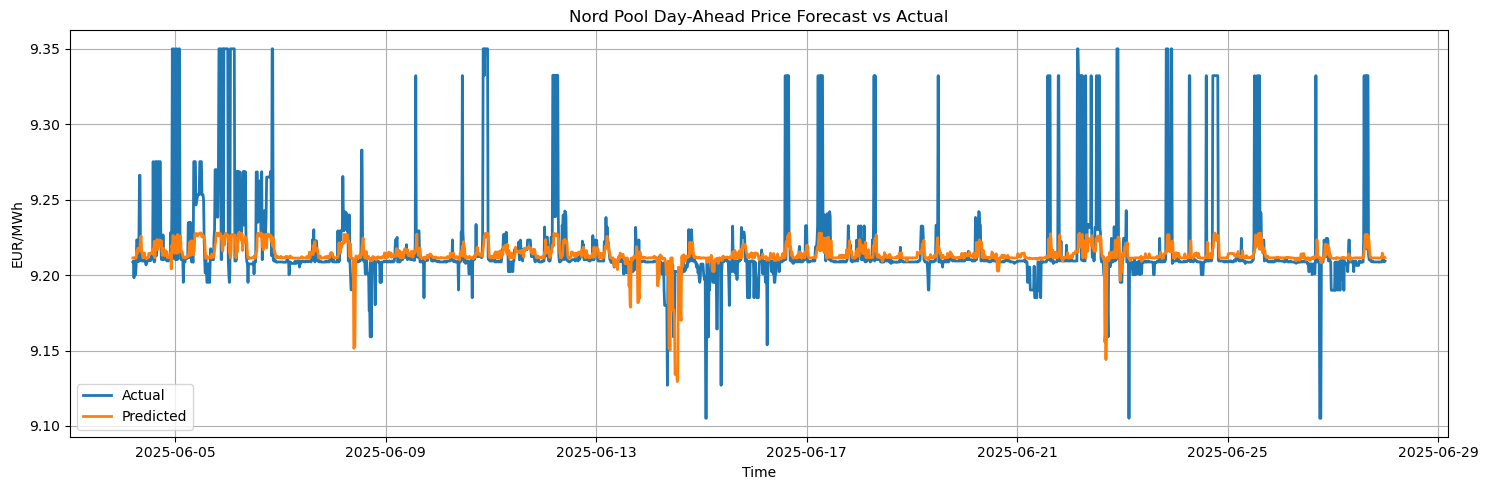

In [26]:
model_lgbm = LGBMRegressor(
    random_state=9,
    subsample=0.8,
    subsample_freq=1,
    n_jobs=-1,
    colsample_bytree=0.2,
    learning_rate=0.005,
    max_depth=2,
    n_estimators=200
)

model_lgbm.fit(X_train, y_train)
y_pred_lgbm = model_lgbm.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_lgbm, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Neural Networks like LSTM could be an option to try, but it needs way more data than 11 000 rows, but it is good with spiky data. 

# Suggestions for Improvements
use wheather data from Latvia and Estonia. Neural Networks like LSTM could be an option to try, but it needs way more data than 11 000 rows, but it is good with spiky data. 